<a href="https://colab.research.google.com/github/ManuelProy/BD_PROYECT/blob/master/Invoice_to_tex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'factura:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4443305%2F7626757%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240214%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240214T231652Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8a4d9dec12995ad2d1d77b321b41a8108372d474bc1b2e03dd057b2ed7af3a330280a6471cdf998390b57d02869e935282a7a84c58e1306eea9c10786fa282aa339330aa7ea2de4a83e3fc64a6610369f4f52323d88aa0f4b938e4c511eb73a1fae7cf332eb1833f645a5f8cec713184d42b5d3cc34050a8e8e5aa00886d398cd45bd9b2a6fbd69b4c12983a360601a586f9b7423142000320db544d35bd9e93bd05ee853be2d516934cb43f4fe5970978b77598ebc37fed14046f6103d4174edabc83da49690d2052ef2d83cc2366ddff6e723cb4eb2c5024f0c9ad3c03797aa41487fb4bdae24a2fbbc97be461dddeaddcb0aaa718dd8244d79cb590fc6164,factura2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4443322%2F7626775%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240214%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240214T231652Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D207597a05253f5db3ea50cfd6786bb10baa98ba39f0ac10d8db1025eb65c01bb4b880b17732e3d22d6ea12b3da649d18bffbafe69954c678bf6ff678b3385a38682d25954013755b2d8062e20fd3c27387cbfb6ddb13f478301eb7361af0fdaa414a2391c13a844cf393aeb93ad005a818b2117718b285ae8ea6111b60db20361f5e3aac1e3eb32bcc86fb4c2066773cbe7aa3b67c4d6a8d0559158a0c7bac7bd62b9fc9cca9876c6d601ae17d3d0da67abe6e52919eb3898d1cdd22f05fa67f61f48e3d4a65e17a6a2e11963920ee86bd45c696dca841e803513b8812c74198bfcf9af01559c2e7d156a7d3572758652575c1d7d3de458ae05a07abebef406a,factura3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4443362%2F7626832%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240214%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240214T231652Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6c0d167db6921fd69fbc889698ff86921722da451d1e6f1cc0880881acc4fce62512cae51b63e1ff058405d2f735a938e541658b74e69a037f99ac0832f07fbcad19dbf6362329af3fb448042be97bd35d57defdb10ab20f5cf5df849a0dedfaf128825541a8d9ca4843ef4ddc0d1badcfe96dce006e321502fa9056d896065ed7d0ff586f7907f31b79e4c6e9ccbc5a824c3357ab6e53cf1edecffc8830c1b8153d83a57cbe127e4d43fb87ab2a1d59583e680599af4375f83b538ecb90a3faff97d97e2bbc323516ad603d04754b9c5231a3b3c1675076ffa264681a7ac25e53cbeecf36291e80fd17797055393b440a7aace9a01bcd5377fce73b76ab452b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Receipt OCR notebook series: Problem definition

> Given a arbitrary photo containing a receipt, extract grand total number

![](https://storage.googleapis.com/www.forwardit.lv/kaggle/receipt_home_kaggle.png)

The solution is divided into smaller tasks:

1. Get a scanned version of receipt by restoring perspective (done in the [previous notebook](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv))
2. **Apply OCR to find all texts within image**
3. **Find grand total as the largest number among recognized texts**

> One should remember that some tasks could be solved with traditional computer vision algorithms

This work aims to address a common pitfall among machine learning practitioners: trying to solve simple problems with the complex tools.

# About this notebook

This is a **part two notebook** in the *Receipt OCR with OpenCV* series. [Previously](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv) we have extracted a scanned version of the receipt out of the image. This notebook deals with the second step of the process: reading text information from it.
* Locating text boxes on the image
* Extracting all the texts from the image
* Obtaining grand total as the largest floating point number among texts

Let's get started!

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

Defining helper methods:

In [ ]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

We will use a scanned version of the receipt, which is the output of the [previous notebook in the series](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv):

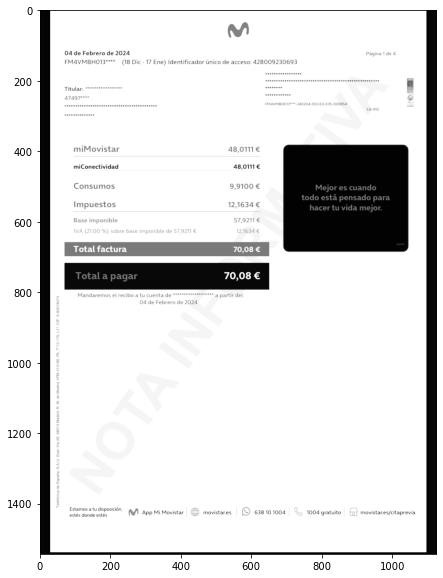

In [ ]:
file_name = "/kaggle/input/factura2/factura2.jpeg"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)

# Step 1: Text box detection

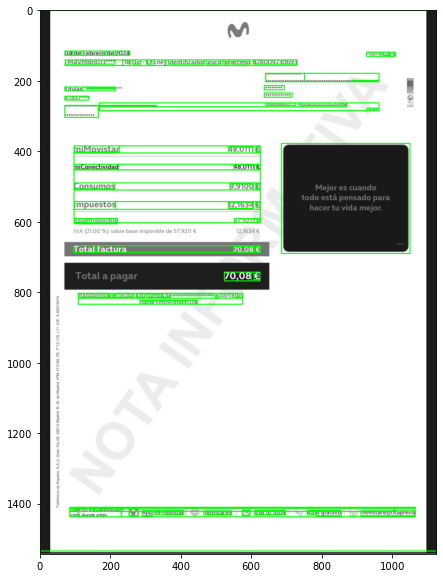

In [ ]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)

In [ ]:
boxes[0]

array([[  0, 255,   0],
       [  0, 255,   0],
       [  0, 255,   0],
       ...,
       [  0, 255,   0],
       [  0, 255,   0],
       [  0, 255,   0]], dtype=uint8)

# Step 2: Text recognition

In [ ]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)
type(extracted_text)


Pagina Ide 4

04 de Febrero de 2024

FM4VMBHO13**** = (18 Dic - 17 Ene) Identificador Gnico de acceso: 428009230693

    

 

Titular; **eteeeeeeee

47497"""*

 

sesnensseeensnssesssenesses FMavaBHo1s 40204.002-£0.035-000854
ca-410

 

miMovistar 48,0111 €
miConectividad 48,011 €
Consumos 9,9100 €
Impuestos 12,1634 €

57,9211 €

Base imponible

Total factu 70,08 €

70,08 €

 

Mandaremos el recibo a tu cuenta de *************"*"*"" a partir del
04 de Febrero de 2024

Est tu dis sicion, &) fs 4
cote donee” A) App Mi Movistar movistares | (S) 638101004 1004 gratuito movistares/citaprevia

 



str

# Step 3: Extracting invoice lines

We will use regular expression to extract all floating point numbers out of the all detected texts.

In [ ]:
extracted_text2={}

In [ ]:
patron = r'\b\d+,\d+\b'
resultados = re.findall(patron, extracted_text)

print(resultados)

['48,0111', '48,011', '9,9100', '12,1634', '57,9211', '70,08', '70,08']


Grand total is the largest one:

In [ ]:
lineas_con_numeros = [linea for linea in extracted_text.splitlines() if re.search(r'\d+\,\d+', linea)]
print(lineas_con_numeros)

['miMovistar 48,0111 €', 'miConectividad 48,011 €', 'Consumos 9,9100 €', 'Impuestos 12,1634 €', '57,9211 €', 'Total factu 70,08 €', '70,08 €']


Feel free to experiment with other regular expressions to find VAT number, company name, date or even read receipt positions!

# About the Author

This notebook is published under the **Data Science DJ** initiative with the goal of giving you distilled pieces of valuable information, short and concise, easy to comprehend.

I spend a few hours every day to write a single post about a single concept. You can find them by:

* [Joining my Telegram channel](https://t.me/datasciencedj)
* [Following my LinkedIn tag](https://www.linkedin.com/feed/hashtag/?keywords=datasciencedj)

If this work gives you joy, or maybe even inspiration, please consider contributing to my [Patreon account](https://www.patreon.com/datasciencedj).
Thank you!

# Resources

1. [OCR a document, form, or invoice with Tesseract, OpenCV, and Python](https://www.pyimagesearch.com/2020/09/07/ocr-a-document-form-or-invoice-with-tesseract-opencv-and-python/) by Adrian Rosebrock
2. [Text Detection and Extraction using OpenCV and OCR](https://www.geeksforgeeks.org/text-detection-and-extraction-using-opencv-and-ocr/) by Anandh Jagadeesan
3. [A comprehensive guide to OCR with Tesseract, OpenCV and Python](https://nanonets.com/blog/ocr-with-tesseract/) by Filip Zelic & Anuj Sable